In [5]:
import imp
import sys
import numpy as np
from argparse import ArgumentParser
from pattern_search import pattern_search
from nelder_mead import nelder_mead_method
from gradient_descent import simple_gradient_descent
import matplotlib.pyplot  as plt

## Import fucntion to optimize

In [6]:
from problems.problem import f, x0, eps

### First function

In [109]:
x0 = np.array([-1.2, 1])
eps = 1e-07

def f(x):
    assert x.size == 2, "Function input vector doesn't matches function dim"
    return 100 * np.square(x[0] * x[0] - x[1]) + np.square(1 - x[0])


### Second function

In [32]:
x0 = np.array([-1.2, -1])
eps = 1e-07

def f(x):
    assert x.size == 2, "Function input vector doesn't matches function dim"
    return 100 * np.square(x[1] - x[0] ** 3) + np.square(1 - x[0])


### Third function

In [64]:
x0 = np.array([3, -1, 0, 1], dtype=float)
eps = 1e-07

def f(x):
    assert x.size == 4, "Function input vector doesn't matches function dim"
    return (x[0] + 10 * x[1]) ** 2 + 5* (x[2] - x[3]) ** 2 + (x[1] - 2 * x[2]) ** 4 + 10 * (x[0] - x[3]) ** 4

## Optimization funcs

### Pattern search

In [69]:
def pattern_search(f, x0, h, l=2, step=2, eps=1e-07,  verbose=False):
    iter = 0
    if verbose: 
        print("Pattern search start:...")
    
    log_data = {'x': [], 'h': [], 'f': []}
    
    without_improvement = 0
    percent = 0.05
    while h > eps:
        x0_old = np.copy(x0)
        for i, x  in enumerate(x0):
            x0_hplus = np.copy(x0)
            x0_hminus = np.copy(x0)
            x0_hplus[i] = x + h
            x0_hminus[i] = x - h
            if f(x0_hplus) < f(x0_hminus) and f(x0_hplus) < f(x0):
                x0 = x0_hplus
            elif f(x0_hminus) < f(x0):
                x0 = x0_hminus
                
        # modification to avoid cycling
        
        if f(x0_old + l * (x0 - x0_old)) < f(x0):
            x0 = x0_old + l * (x0 - x0_old)
        if verbose:
            print(f'iter {iter}: x = {x0} f(x) = {f(x0)} h = {h}')
        
        log_data['x'].append(x0)
        log_data['h'].append(h)
        log_data['f'].append(f(x0))
        iter += 1
        if np.array_equal(x0, x0_old):
            h = h / step
            continue
    print(f'Total iter: {iter}')
    
    print(f'Final: {iter}: x = {x0} f(x) = {f(x0)} h = {h}')
    
    plt.plot([item[0] for item in log_data['x']], [item[1] for item in log_data['x']])
    #axs[1].plot(log_data['f'])
    #plt.yscale('log')
    #plt.plot(log_data['h'])
    plt.show()
    

### Symplex method (Nelder Method)

In [13]:
from functools import reduce

def init_simplex(x0, init_eps=1e-01):
    simplex = [x0]
    for dim, x in enumerate(x0):
        x_new = x0.copy()
        x_new[dim] = x + init_eps
        simplex.append(x_new)
    return simplex

def calculate_centroid(simplex):
    return 1 / (len(simplex)) *  reduce(lambda a, b: a + b['x'], simplex, np.zeros(simplex[0]['x'].shape))

def shrink_simplex(simplex, center, f, sigma=0.5):
    new_simplex = [{'x': center + sigma * (item['x'] - center),
     'fx': f(center + sigma * (item['x'] - center))}
      for item in simplex]
    return new_simplex

def nelder_mead_method(f, x0, a=1, b=0.5, gamma=2, sigma=0.5, eps=1e-03, init_simplex_eps=1e-01, verbose=False):
    """
    a: reflection coef
    b: contradiction coef
    gamma: expansion coef
    sigma: shrink (global shrink) coef
    """
    data_x = []
    simplex = init_simplex(x0, init_eps=init_simplex_eps)
    simplex = [{'x': x, 'fx': f(x)} for x in simplex]
    simplex = sorted(simplex, key=lambda item: item['fx'], reverse=True)
    delta = 2 * eps
    iter = 0
    while delta > eps:
        xh_point = simplex[0]
        xg_point = simplex[1]
        xl_point = simplex[-1]
        xc_point = {'x': calculate_centroid(simplex[1:]), 'fx': f(calculate_centroid(simplex[1:]))}
        # reflection
        xr_point = {'x': (1 + a) * xc_point['x'] - a * xh_point['x'],
         'fx': f((1 + a) * xc_point['x'] - a * xh_point['x'])}
        if xr_point['fx'] < xl_point['fx']:
            # expansion
            xe_point = {'x': (1 - gamma) * xc_point['x'] +  gamma * xr_point['x'],
             'fx': f((1 - gamma) * xc_point['x'] +  gamma * xr_point['x'])}
            if xe_point['fx'] < xr_point['fx']:
                xh_point['x'] = xe_point['x']
                xh_point['fx'] = xe_point['fx']
            else: 
                xh_point['x'] = xr_point['x']
                xh_point['fx'] = xr_point['fx']
        elif xl_point['fx'] < xr_point['fx'] and xr_point['fx'] < xg_point['fx']:
            xh_point['x'] = xr_point['x']
            xh_point['fx'] = xr_point['fx']
        else:
            if xg_point['fx'] < xr_point['fx'] and xr_point['fx'] < xh_point['fx']:
                temp = {'x': xh_point['x'], 'fx': xh_point['fx']}
                xh_point['x'] = xr_point['x']
                xh_point['fx'] = xr_point['fx']
                xr_point['x'] = temp['x']
                xr_point['fx'] = temp['fx']
            # condradiction
            xs_point = {'x': b * xh_point['x'] + (1 - b) * xc_point['x'],
            'fx': f(b * xh_point['x'] + (1 - b) * xc_point['x'])}
            if xs_point['fx'] < xh_point['fx']:
                xh_point['x'] = xs_point['x']
                xh_point['fx'] = xs_point['fx']
            else:
                # shrink
                simplex = shrink_simplex(simplex, xl_point['x'], f, sigma=sigma)
        # calculate delta
        delta = np.sqrt(np.mean(np.var(np.array([item['x'] for item in simplex]), axis=0)))
        # ToDo: do not sort
        simplex = sorted(simplex, key=lambda item: item['fx'], reverse=True)
        iter += 1
        if verbose:
            print(f"Iter: {iter} x: {simplex[-1]['x']} fx: {simplex[-1]['fx']} delta: {delta}")
        data_x.append(simplex[-1]['x'])
    
    print(f'Final: {iter}: x = {simplex[-1]["x"]} f(x) = {f(simplex[-1]["x"])}')
    print(f'Total iter: {iter}')
    plt.plot([item[0] for item in data_x], [item[1] for item in data_x])
    plt.show()


### Basic gradient descent

In [2]:
from autograd import grad

def simple_gradient_descent(f, x0, lr=1e-03, patience=10,  threshold=1e-05, final_lr=1e-07):
    derivative_fn = grad(f)
    iter = 0
    min_fx = 1000000
    waiting = 0
    iter = 0
    while True:
        fx = f(x0)
        x0 -= lr * derivative_fn(x0)
        if min_fx - fx > threshold:
            min_fx = fx
            waiting = 0
        elif waiting > patience:
            lr = lr / 3
            waiting = 0
            if lr < final_lr:
                break
        print(f'Iter: {iter} x: {x0} fx: {fx} lr: {lr}')
        waiting += 1
        iter += 1

## Run optimization

Total iter: 3152
Final: 3152: x = [0.99996147 0.99992294] f(x) = 1.4844410935123458e-09 h = 9.5367431640625e-08


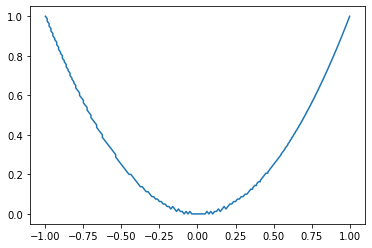

In [110]:
pattern_search(f, x0, h=2e-01, l=2, eps=eps, verbose=False)

Final: 141: x = [1.00000003 1.0000001 ] f(x) = 1.1462698332056038e-15
Total iter: 141


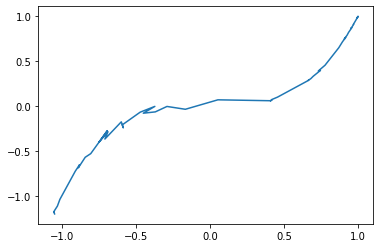

In [14]:
nelder_mead_method(f, x0, a=2, b=1, gamma=2, eps=eps, init_simplex_eps=1e-01, verbose=False)

In [33]:
simple_gradient_descent(f, x0, lr=1e-3, patience=10,  threshold=1e-05, final_lr=eps)

Iter: 0 x: [-0.566608 -1.1456  ] fx: 57.83839999999997 lr: 0.001
Iter: 1 x: [-0.74910796 -0.95286129] fx: 95.3247858288376 lr: 0.001
Iter: 2 x: [-0.92489781 -0.84636333] fx: 31.413918561607066 lr: 0.001
Iter: 3 x: [-0.94936593 -0.83532883] fx: 4.0096317728925355 lr: 0.001
Iter: 4 x: [-0.93447289 -0.83939495] fx: 3.841360711920032 lr: 0.001
Iter: 5 x: [-0.94285178 -0.8347197 ] fx: 3.7968302016214186 lr: 0.001
Iter: 6 x: [-0.93712764 -0.83540905] fx: 3.7758610244662085 lr: 0.001
Iter: 7 x: [-0.93979561 -0.83292588] fx: 3.7678788401572603 lr: 0.001
Iter: 8 x: [-0.9374441  -0.83234917] fx: 3.7636384955027875 lr: 0.001
Iter: 9 x: [-0.93806267 -0.83064478] fx: 3.7609519858742924 lr: 0.001
Iter: 10 x: [-0.93692446 -0.82960764] fx: 3.7587760326283157 lr: 0.001
Iter: 11 x: [-0.9368163  -0.82817772] fx: 3.756788095926926 lr: 0.001
Iter: 12 x: [-0.9361045  -0.82697681] fx: 3.754862800613874 lr: 0.001
Iter: 13 x: [-0.93574251 -0.82564156] fx: 3.752957889580822 lr: 0.001
Iter: 14 x: [-0.93517679 -0

Iter: 188 x: [-0.83479607 -0.58889312] fx: 3.374073476938957 lr: 0.001
Iter: 189 x: [-0.83411055 -0.58746578] fx: 3.371569851963439 lr: 0.001
Iter: 190 x: [-0.83342345 -0.5860375 ] fx: 3.369061409076697 lr: 0.001
Iter: 191 x: [-0.83273476 -0.58460829] fx: 3.366548127187916 lr: 0.001
Iter: 192 x: [-0.83204448 -0.58317815] fx: 3.364029985072115 lr: 0.001
Iter: 193 x: [-0.8313526  -0.58174707] fx: 3.361506961369086 lr: 0.001
Iter: 194 x: [-0.8306591  -0.58031505] fx: 3.3589790345823465 lr: 0.001
Iter: 195 x: [-0.82996399 -0.57888209] fx: 3.3564461830780696 lr: 0.001
Iter: 196 x: [-0.82926725 -0.57744819] fx: 3.3539083850840092 lr: 0.001
Iter: 197 x: [-0.82856888 -0.57601334] fx: 3.3513656186884138 lr: 0.001
Iter: 198 x: [-0.82786886 -0.57457755] fx: 3.3488178618389357 lr: 0.001
Iter: 199 x: [-0.8271672  -0.57314081] fx: 3.346265092341527 lr: 0.001
Iter: 200 x: [-0.82646387 -0.57170313] fx: 3.3437072878593295 lr: 0.001
Iter: 201 x: [-0.82575888 -0.5702645 ] fx: 3.3411444259115504 lr: 0.001

Iter: 355 x: [-0.69042957 -0.33705166] fx: 2.867583762528436 lr: 0.001
Iter: 356 x: [-0.68931645 -0.33546591] fx: 2.863838592463349 lr: 0.001
Iter: 357 x: [-0.68819926 -0.33387946] fx: 2.8600821451356584 lr: 0.001
Iter: 358 x: [-0.68707797 -0.33229231] fx: 2.856314356800873 lr: 0.001
Iter: 359 x: [-0.68595256 -0.33070447] fx: 2.8525351633653737 lr: 0.001
Iter: 360 x: [-0.68482299 -0.32911595] fx: 2.8487445003881886 lr: 0.001
Iter: 361 x: [-0.68368925 -0.32752677] fx: 2.8449423030829464 lr: 0.001
Iter: 362 x: [-0.6825513  -0.32593692] fx: 2.841128506319989 lr: 0.001
Iter: 363 x: [-0.68140912 -0.32434643] fx: 2.8373030446286767 lr: 0.001
Iter: 364 x: [-0.68026267 -0.3227553 ] fx: 2.8334658521998635 lr: 0.001
Iter: 365 x: [-0.67911194 -0.32116354] fx: 2.8296168628885794 lr: 0.001
Iter: 366 x: [-0.67795688 -0.31957117] fx: 2.825756010216898 lr: 0.001
Iter: 367 x: [-0.67679749 -0.3179782 ] fx: 2.8218832273770156 lr: 0.001
Iter: 368 x: [-0.67563371 -0.31638463] fx: 2.817998447234543 lr: 0.00

Iter: 493 x: [-0.48477632 -0.12098909] fx: 2.2154274326276586 lr: 0.001
Iter: 494 x: [-0.48280264 -0.11957654] fx: 2.2095489375275386 lr: 0.001
Iter: 495 x: [-0.48082109 -0.11816934] fx: 2.2036542395897296 lr: 0.001
Iter: 496 x: [-0.47883167 -0.11676757] fx: 2.197743467316881 lr: 0.001
Iter: 497 x: [-0.47683439 -0.11537134] fx: 2.191816754797214 lr: 0.001
Iter: 498 x: [-0.47482927 -0.11398074] fx: 2.185874241766564 lr: 0.001
Iter: 499 x: [-0.47281632 -0.11259586] fx: 2.179916073667308 lr: 0.001
Iter: 500 x: [-0.47079557 -0.1112168 ] fx: 2.17394240170397 lr: 0.001
Iter: 501 x: [-0.46876704 -0.10984367] fx: 2.1679533828953184 lr: 0.001
Iter: 502 x: [-0.46673075 -0.10847655] fx: 2.1619491801227637 lr: 0.001
Iter: 503 x: [-0.46468673 -0.10711554] fx: 2.15592996217486 lr: 0.001
Iter: 504 x: [-0.46263499 -0.10576074] fx: 2.1498959037877077 lr: 0.001
Iter: 505 x: [-0.46057558 -0.10441225] fx: 2.1438471856810786 lr: 0.001
Iter: 506 x: [-0.45850852 -0.10307017] fx: 2.1377839945900563 lr: 0.001


Iter: 639 x: [-0.149149  -0.0042023] fx: 1.3258956378286875 lr: 0.001
Iter: 640 x: [-0.14686251 -0.00402542] fx: 1.320621651558993 lr: 0.001
Iter: 641 x: [-0.14457989 -0.00385386] fx: 1.31536719869164 lr: 0.001
Iter: 642 x: [-0.14230116 -0.00368753] fx: 1.3101322800495245 lr: 0.001
Iter: 643 x: [-0.14002635 -0.00352633] fx: 1.3049168933857946 lr: 0.001
Iter: 644 x: [-0.13775548 -0.00337017] fx: 1.2997210334756721 lr: 0.001
Iter: 645 x: [-0.13548858 -0.00321896] fx: 1.2945446922072728 lr: 0.001
Iter: 646 x: [-0.13322566 -0.00307261] fx: 1.2893878586713643 lr: 0.001
Iter: 647 x: [-0.13096675 -0.00293101] fx: 1.284250519249999 lr: 0.001
Iter: 648 x: [-0.12871186 -0.00279409] fx: 1.279132657703986 lr: 0.001
Iter: 649 x: [-0.12646101 -0.00266174] fx: 1.27403425525914 lr: 0.001
Iter: 650 x: [-0.12421423 -0.00253387] fx: 1.2689552906912815 lr: 0.001
Iter: 651 x: [-0.12197151 -0.0024104 ] fx: 1.263895740409941 lr: 0.001
Iter: 652 x: [-0.11973289 -0.00229124] fx: 1.2588555785407376 lr: 0.001
It

Iter: 803 x: [0.17211409 0.0044219 ] fx: 0.6881698046906936 lr: 0.001
Iter: 804 x: [0.17375784 0.00455724] fx: 0.6854408628969527 lr: 0.001
Iter: 805 x: [0.17539784 0.004695  ] fx: 0.6827235570313341 lr: 0.001
Iter: 806 x: [0.17703411 0.0048352 ] fx: 0.6800178556908123 lr: 0.001
Iter: 807 x: [0.17866663 0.00497785] fx: 0.677323727631868 lr: 0.001
Iter: 808 x: [0.1802954  0.00512295] fx: 0.6746411417644965 lr: 0.001
Iter: 809 x: [0.18192042 0.00527051] fx: 0.671970067146235 lr: 0.001
Iter: 810 x: [0.18354168 0.00542054] fx: 0.66931047297621 lr: 0.001
Iter: 811 x: [0.18515919 0.00557305] fx: 0.6666623285892113 lr: 0.001
Iter: 812 x: [0.18677293 0.00572804] fx: 0.6640256034497889 lr: 0.001
Iter: 813 x: [0.1883829  0.00588551] fx: 0.661400267146384 lr: 0.001
Iter: 814 x: [0.1899891  0.00604548] fx: 0.6587862893854876 lr: 0.001
Iter: 815 x: [0.19159153 0.00620795] fx: 0.6561836399858368 lr: 0.001
Iter: 816 x: [0.19319018 0.00637292] fx: 0.6535922888726478 lr: 0.001
Iter: 817 x: [0.19478505 

Iter: 957 x: [0.37950332 0.05241382] fx: 0.38682216583676265 lr: 0.001
Iter: 958 x: [0.38055046 0.05286248] fx: 0.3855193700063618 lr: 0.001
Iter: 959 x: [0.381594   0.05331214] fx: 0.3842232283397257 lr: 0.001
Iter: 960 x: [0.38263395 0.0537628 ] fx: 0.3829337061432336 lr: 0.001
Iter: 961 x: [0.38367031 0.05421443] fx: 0.38165076878558035 lr: 0.001
Iter: 962 x: [0.3847031  0.05466702] fx: 0.38037438170001 lr: 0.001
Iter: 963 x: [0.38573233 0.05512056] fx: 0.3791045103865173 lr: 0.001
Iter: 964 x: [0.38675801 0.05557503] fx: 0.3778411204140233 lr: 0.001
Iter: 965 x: [0.38778014 0.05603041] fx: 0.3765841774225191 lr: 0.001
Iter: 966 x: [0.38879874 0.05648669] fx: 0.3753336471251806 lr: 0.001
Iter: 967 x: [0.38981382 0.05694386] fx: 0.37408949531045127 lr: 0.001
Iter: 968 x: [0.39082538 0.05740191] fx: 0.37285168784409617 lr: 0.001
Iter: 969 x: [0.39183345 0.05786081] fx: 0.3716201906712213 lr: 0.001
Iter: 970 x: [0.39283802 0.05832056] fx: 0.37039496981826386 lr: 0.001
Iter: 971 x: [0.3

Iter: 1172 x: [0.53976749 0.15497331] fx: 0.21281891524188917 lr: 0.001
Iter: 1173 x: [0.5402881  0.15543078] fx: 0.21233717438874733 lr: 0.001
Iter: 1174 x: [0.54080725 0.15588786] fx: 0.21185732804927795 lr: 0.001
Iter: 1175 x: [0.54132494 0.15634453] fx: 0.21137936567525006 lr: 0.001
Iter: 1176 x: [0.54184118 0.15680081] fx: 0.21090327678939444 lr: 0.001
Iter: 1177 x: [0.54235598 0.15725668] fx: 0.2104290509849019 lr: 0.001
Iter: 1178 x: [0.54286934 0.15771215] fx: 0.2099566779249243 lr: 0.001
Iter: 1179 x: [0.54338127 0.15816721] fx: 0.20948614734207832 lr: 0.001
Iter: 1180 x: [0.54389178 0.15862186] fx: 0.20901744903795239 lr: 0.001
Iter: 1181 x: [0.54440086 0.15907612] fx: 0.20855057288261625 lr: 0.001
Iter: 1182 x: [0.54490854 0.15952996] fx: 0.20808550881413362 lr: 0.001
Iter: 1183 x: [0.54541481 0.1599834 ] fx: 0.2076222468380776 lr: 0.001
Iter: 1184 x: [0.54591969 0.16043642] fx: 0.2071607770270491 lr: 0.001
Iter: 1185 x: [0.54642317 0.16088904] fx: 0.20670108952019806 lr: 0.

Iter: 1421 x: [0.63654727 0.25613707] fx: 0.13263094946188228 lr: 0.001
Iter: 1422 x: [0.63683971 0.25649448] fx: 0.1324172490301233 lr: 0.001
Iter: 1423 x: [0.6371316  0.25685154] fx: 0.13220412666520925 lr: 0.001
Iter: 1424 x: [0.63742293 0.25720825] fx: 0.13199158004974162 lr: 0.001
Iter: 1425 x: [0.63771371 0.2575646 ] fx: 0.13177960687857068 lr: 0.001
Iter: 1426 x: [0.63800394 0.25792061] fx: 0.13156820485871656 lr: 0.001
Iter: 1427 x: [0.63829363 0.25827627] fx: 0.13135737170929107 lr: 0.001
Iter: 1428 x: [0.63858277 0.25863157] fx: 0.13114710516141995 lr: 0.001
Iter: 1429 x: [0.63887136 0.25898653] fx: 0.13093740295816594 lr: 0.001
Iter: 1430 x: [0.63915941 0.25934114] fx: 0.1307282628544522 lr: 0.001
Iter: 1431 x: [0.63944692 0.2596954 ] fx: 0.13051968261698638 lr: 0.001
Iter: 1432 x: [0.63973389 0.26004931] fx: 0.1303116600241852 lr: 0.001
Iter: 1433 x: [0.64002032 0.26040288] fx: 0.13010419286609964 lr: 0.001
Iter: 1434 x: [0.64030622 0.26075609] fx: 0.1298972789443409 lr: 0.

Iter: 1561 x: [0.67279345 0.30297563] fx: 0.10745989335597733 lr: 0.001
Iter: 1562 x: [0.67302282 0.30328864] fx: 0.10730905323929028 lr: 0.001
Iter: 1563 x: [0.67325183 0.30360135] fx: 0.1071585579502752 lr: 0.001
Iter: 1564 x: [0.67348047 0.30391379] fx: 0.10700840632201775 lr: 0.001
Iter: 1565 x: [0.67370876 0.30422594] fx: 0.10685859719287194 lr: 0.001
Iter: 1566 x: [0.67393669 0.30453781] fx: 0.10670912940643049 lr: 0.001
Iter: 1567 x: [0.67416425 0.3048494 ] fx: 0.1065600018114957 lr: 0.001
Iter: 1568 x: [0.67439146 0.3051607 ] fx: 0.10641121326205034 lr: 0.001
Iter: 1569 x: [0.67461831 0.30547173] fx: 0.10626276261722867 lr: 0.001
Iter: 1570 x: [0.67484481 0.30578247] fx: 0.1061146487412878 lr: 0.001
Iter: 1571 x: [0.67507095 0.30609294] fx: 0.1059668705035793 lr: 0.001
Iter: 1572 x: [0.67529673 0.30640312] fx: 0.10581942677852064 lr: 0.001
Iter: 1573 x: [0.67552216 0.30671303] fx: 0.10567231644556731 lr: 0.001
Iter: 1574 x: [0.67574724 0.30702265] fx: 0.1055255383891846 lr: 0.0

Iter: 1734 x: [0.70780506 0.35325251] fx: 0.08566489864562198 lr: 0.001
Iter: 1735 x: [0.70798385 0.35352237] fx: 0.0855599532606016 lr: 0.001
Iter: 1736 x: [0.7081624  0.35379203] fx: 0.08545520978386789 lr: 0.001
Iter: 1737 x: [0.70834072 0.35406146] fx: 0.08535066764545154 lr: 0.001
Iter: 1738 x: [0.70851881 0.35433067] fx: 0.08524632627754028 lr: 0.001
Iter: 1739 x: [0.70869666 0.35459967] fx: 0.08514218511446879 lr: 0.001
Iter: 1740 x: [0.70887428 0.35486845] fx: 0.08503824359270838 lr: 0.001
Iter: 1741 x: [0.70905167 0.35513702] fx: 0.08493450115085696 lr: 0.001
Iter: 1742 x: [0.70922883 0.35540536] fx: 0.08483095722962909 lr: 0.001
Iter: 1743 x: [0.70940575 0.3556735 ] fx: 0.08472761127184585 lr: 0.001
Iter: 1744 x: [0.70958245 0.35594141] fx: 0.08462446272242492 lr: 0.001
Iter: 1745 x: [0.70975892 0.35620911] fx: 0.08452151102837094 lr: 0.001
Iter: 1746 x: [0.70993516 0.3564766 ] fx: 0.08441875563876529 lr: 0.001
Iter: 1747 x: [0.71011117 0.35674387] fx: 0.08431619600475672 lr:

Iter: 1848 x: [0.72679664 0.38268382] fx: 0.07487759324306693 lr: 0.001
Iter: 1849 x: [0.72695181 0.3829307 ] fx: 0.07479245234579641 lr: 0.001
Iter: 1850 x: [0.7271068 0.3831774] fx: 0.07470746015439254 lr: 0.001
Iter: 1851 x: [0.72726161 0.38342391] fx: 0.0746226162907246 lr: 0.001
Iter: 1852 x: [0.72741623 0.38367023] fx: 0.07453792037795136 lr: 0.001
Iter: 1853 x: [0.72757068 0.38391638] fx: 0.07445337204051555 lr: 0.001
Iter: 1854 x: [0.72772494 0.38416233] fx: 0.07436897090413848 lr: 0.001
Iter: 1855 x: [0.72787902 0.3844081 ] fx: 0.07428471659581443 lr: 0.001
Iter: 1856 x: [0.72803292 0.38465369] fx: 0.07420060874380531 lr: 0.001
Iter: 1857 x: [0.72818664 0.38489909] fx: 0.07411664697763523 lr: 0.001
Iter: 1858 x: [0.72834018 0.38514431] fx: 0.07403283092808513 lr: 0.001
Iter: 1859 x: [0.72849355 0.38538934] fx: 0.07394916022718738 lr: 0.001
Iter: 1860 x: [0.72864673 0.38563419] fx: 0.07386563450822048 lr: 0.001
Iter: 1861 x: [0.72879973 0.38587886] fx: 0.07378225340570382 lr: 0

Iter: 2073 x: [0.75771392 0.43397361] fx: 0.05887268270448671 lr: 0.001
Iter: 2074 x: [0.75783577 0.4341842 ] fx: 0.058813420094465926 lr: 0.001
Iter: 2075 x: [0.75795749 0.43439466] fx: 0.05875424559126871 lr: 0.001
Iter: 2076 x: [0.7580791  0.43460498] fx: 0.05869515900741045 lr: 0.001
Iter: 2077 x: [0.75820058 0.43481515] fx: 0.05863616015594014 lr: 0.001
Iter: 2078 x: [0.75832195 0.43502519] fx: 0.05857724885043843 lr: 0.001
Iter: 2079 x: [0.7584432  0.43523509] fx: 0.058518424905015846 lr: 0.001
Iter: 2080 x: [0.75856432 0.43544485] fx: 0.05845968813431078 lr: 0.001
Iter: 2081 x: [0.75868533 0.43565447] fx: 0.05840103835348771 lr: 0.001
Iter: 2082 x: [0.75880623 0.43586395] fx: 0.05834247537823519 lr: 0.001
Iter: 2083 x: [0.758927  0.4360733] fx: 0.0582839990247641 lr: 0.001
Iter: 2084 x: [0.75904766 0.43628251] fx: 0.05822560910980569 lr: 0.001
Iter: 2085 x: [0.7591682  0.43649157] fx: 0.0581673054506098 lr: 0.001
Iter: 2086 x: [0.75928862 0.4367005 ] fx: 0.05810908786494296 lr: 

Iter: 2216 x: [0.77401184 0.46274523] fx: 0.05121131702740786 lr: 0.001
Iter: 2217 x: [0.77411842 0.4629374 ] fx: 0.051162976303961986 lr: 0.001
Iter: 2218 x: [0.77422491 0.46312946] fx: 0.05111470150339079 lr: 0.001
Iter: 2219 x: [0.7743313 0.4633214] fx: 0.051066492498446546 lr: 0.001
Iter: 2220 x: [0.7744376  0.46351322] fx: 0.051018349162209105 lr: 0.001
Iter: 2221 x: [0.7745438  0.46370492] fx: 0.050970271368084796 lr: 0.001
Iter: 2222 x: [0.77464991 0.46389651] fx: 0.050922258989805326 lr: 0.001
Iter: 2223 x: [0.77475592 0.46408797] fx: 0.05087431190142681 lr: 0.001
Iter: 2224 x: [0.77486184 0.46427932] fx: 0.05082642997732868 lr: 0.001
Iter: 2225 x: [0.77496767 0.46447055] fx: 0.05077861309221264 lr: 0.001
Iter: 2226 x: [0.7750734  0.46466167] fx: 0.05073086112110158 lr: 0.001
Iter: 2227 x: [0.77517904 0.46485266] fx: 0.050683173939338654 lr: 0.001
Iter: 2228 x: [0.77528458 0.46504354] fx: 0.05063555142258614 lr: 0.001
Iter: 2229 x: [0.77539003 0.4652343 ] fx: 0.0505879934468244

Iter: 2375 x: [0.78985357 0.49189085] fx: 0.04427718223347041 lr: 0.001
Iter: 2376 x: [0.78994669 0.49206566] fx: 0.044237915935647555 lr: 0.001
Iter: 2377 x: [0.79003974 0.49224037] fx: 0.0441986988378187 lr: 0.001
Iter: 2378 x: [0.79013271 0.49241498] fx: 0.04415953085379061 lr: 0.001
Iter: 2379 x: [0.7902256  0.49258948] fx: 0.044120411897570544 lr: 0.001
Iter: 2380 x: [0.79031842 0.49276389] fx: 0.04408134188336577 lr: 0.001
Iter: 2381 x: [0.79041117 0.4929382 ] fx: 0.04404232072558292 lr: 0.001
Iter: 2382 x: [0.79050384 0.4931124 ] fx: 0.04400334833882742 lr: 0.001
Iter: 2383 x: [0.79059643 0.49328651] fx: 0.0439644246379029 lr: 0.001
Iter: 2384 x: [0.79068896 0.49346052] fx: 0.04392554953781063 lr: 0.001
Iter: 2385 x: [0.7907814  0.49363443] fx: 0.04388672295374892 lr: 0.001
Iter: 2386 x: [0.79087377 0.49380823] fx: 0.04384794480111262 lr: 0.001
Iter: 2387 x: [0.79096607 0.49398194] fx: 0.04380921499549243 lr: 0.001
Iter: 2388 x: [0.7910583  0.49415555] fx: 0.0437705334526744 lr:

Iter: 2535 x: [0.80385928 0.51864602] fx: 0.038567487764030475 lr: 0.001
Iter: 2536 x: [0.80394155 0.51880594] fx: 0.03853511753503053 lr: 0.001
Iter: 2537 x: [0.80402375 0.51896578] fx: 0.03850278492096561 lr: 0.001
Iter: 2538 x: [0.80410589 0.51912553] fx: 0.038470489861454175 lr: 0.001
Iter: 2539 x: [0.80418797 0.51928519] fx: 0.0384382322962428 lr: 0.001
Iter: 2540 x: [0.80426999 0.51944477] fx: 0.03840601216520585 lr: 0.001
Iter: 2541 x: [0.80435195 0.51960426] fx: 0.038373829408345245 lr: 0.001
Iter: 2542 x: [0.80443385 0.51976366] fx: 0.03834168396578996 lr: 0.001
Iter: 2543 x: [0.80451569 0.51992298] fx: 0.038309575777795736 lr: 0.001
Iter: 2544 x: [0.80459747 0.52008222] fx: 0.03827750478474484 lr: 0.001
Iter: 2545 x: [0.80467918 0.52024137] fx: 0.03824547092714558 lr: 0.001
Iter: 2546 x: [0.80476084 0.52040043] fx: 0.038213474145632066 lr: 0.001
Iter: 2547 x: [0.80484244 0.52055941] fx: 0.03818151438096389 lr: 0.001
Iter: 2548 x: [0.80492397 0.5207183 ] fx: 0.0381495915740257

Iter: 2707 x: [0.81717038 0.54494878] fx: 0.03350679591751646 lr: 0.001
Iter: 2708 x: [0.81724316 0.54509498] fx: 0.03348010341636285 lr: 0.001
Iter: 2709 x: [0.8173159 0.5452411] fx: 0.03345343977849351 lr: 0.001
Iter: 2710 x: [0.81738859 0.54538715] fx: 0.03342680496132986 lr: 0.001
Iter: 2711 x: [0.81746122 0.54553312] fx: 0.03340019892237594 lr: 0.001
Iter: 2712 x: [0.81753381 0.54567902] fx: 0.0333736216192182 lr: 0.001
Iter: 2713 x: [0.81760635 0.54582485] fx: 0.03334707300952527 lr: 0.001
Iter: 2714 x: [0.81767884 0.5459706 ] fx: 0.03332055305104783 lr: 0.001
Iter: 2715 x: [0.81775128 0.54611628] fx: 0.03329406170161832 lr: 0.001
Iter: 2716 x: [0.81782367 0.54626189] fx: 0.03326759891915083 lr: 0.001
Iter: 2717 x: [0.81789601 0.54640742] fx: 0.033241164661640815 lr: 0.001
Iter: 2718 x: [0.8179683  0.54655288] fx: 0.033214758887165 lr: 0.001
Iter: 2719 x: [0.81804054 0.54669826] fx: 0.0331883815538811 lr: 0.001
Iter: 2720 x: [0.81811274 0.54684357] fx: 0.03316203262002765 lr: 0.0

Iter: 2872 x: [0.82854693 0.5681152 ] fx: 0.02946403330713344 lr: 0.001
Iter: 2873 x: [0.82861222 0.56825   ] fx: 0.02944158241688578 lr: 0.001
Iter: 2874 x: [0.82867747 0.56838473] fx: 0.029419154350085474 lr: 0.001
Iter: 2875 x: [0.82874268 0.5685194 ] fx: 0.02939674907544307 lr: 0.001
Iter: 2876 x: [0.82880785 0.56865401] fx: 0.02937436656172524 lr: 0.001
Iter: 2877 x: [0.82887297 0.56878855] fx: 0.029352006777754704 lr: 0.001
Iter: 2878 x: [0.82893806 0.56892303] fx: 0.02932966969240996 lr: 0.001
Iter: 2879 x: [0.8290031  0.56905744] fx: 0.02930735527462533 lr: 0.001
Iter: 2880 x: [0.8290681  0.56919179] fx: 0.02928506349339073 lr: 0.001
Iter: 2881 x: [0.82913306 0.56932607] fx: 0.029262794317751587 lr: 0.001
Iter: 2882 x: [0.82919798 0.56946029] fx: 0.029240547716808663 lr: 0.001
Iter: 2883 x: [0.82926286 0.56959445] fx: 0.029218323659717986 lr: 0.001
Iter: 2884 x: [0.8293277  0.56972854] fx: 0.029196122115690733 lr: 0.001
Iter: 2885 x: [0.8293925  0.56986257] fx: 0.02917394305399

Iter: 3071 x: [0.84077525 0.59373206] fx: 0.025408742703600964 lr: 0.001
Iter: 3072 x: [0.84083306 0.59385496] fx: 0.025390282621424995 lr: 0.001
Iter: 3073 x: [0.84089085 0.5939778 ] fx: 0.025371840097841075 lr: 0.001
Iter: 3074 x: [0.8409486  0.59410059] fx: 0.025353415110624982 lr: 0.001
Iter: 3075 x: [0.84100631 0.59422332] fx: 0.025335007637589082 lr: 0.001
Iter: 3076 x: [0.84106399 0.594346  ] fx: 0.025316617656582278 lr: 0.001
Iter: 3077 x: [0.84112164 0.59446862] fx: 0.025298245145489808 lr: 0.001
Iter: 3078 x: [0.84117925 0.59459119] fx: 0.025279890082233303 lr: 0.001
Iter: 3079 x: [0.84123683 0.5947137 ] fx: 0.025261552444770644 lr: 0.001
Iter: 3080 x: [0.84129438 0.59483616] fx: 0.02524323221109593 lr: 0.001
Iter: 3081 x: [0.84135189 0.59495856] fx: 0.02522492935923935 lr: 0.001
Iter: 3082 x: [0.84140937 0.59508091] fx: 0.025206643867267134 lr: 0.001
Iter: 3083 x: [0.84146682 0.5952032 ] fx: 0.0251883757132815 lr: 0.001
Iter: 3084 x: [0.84152423 0.59532543] fx: 0.02517012487

Iter: 3209 x: [0.84844619 0.61018517] fx: 0.02301821009201674 lr: 0.001
Iter: 3210 x: [0.84849961 0.61030079] fx: 0.02300197766020849 lr: 0.001
Iter: 3211 x: [0.84855299 0.61041636] fx: 0.0229857600359815 lr: 0.001
Iter: 3212 x: [0.84860635 0.61053187] fx: 0.022969557201519386 lr: 0.001
Iter: 3213 x: [0.84865968 0.61064734] fx: 0.022953369139033515 lr: 0.001
Iter: 3214 x: [0.84871298 0.61076276] fx: 0.0229371958307629 lr: 0.001
Iter: 3215 x: [0.84876625 0.61087813] fx: 0.02292103725897423 lr: 0.001
Iter: 3216 x: [0.84881949 0.61099345] fx: 0.022904893405961736 lr: 0.001
Iter: 3217 x: [0.8488727  0.61110872] fx: 0.022888764254047185 lr: 0.001
Iter: 3218 x: [0.84892588 0.61122394] fx: 0.022872649785579832 lr: 0.001
Iter: 3219 x: [0.84897903 0.61133911] fx: 0.022856549982936347 lr: 0.001
Iter: 3220 x: [0.84903215 0.61145423] fx: 0.02284046482852076 lr: 0.001
Iter: 3221 x: [0.84908524 0.61156929] fx: 0.022824394304764403 lr: 0.001
Iter: 3222 x: [0.8491383  0.61168431] fx: 0.022808338394125

Iter: 3393 x: [0.85779813 0.63064829] fx: 0.020263743940685957 lr: 0.001
Iter: 3394 x: [0.85784647 0.63075523] fx: 0.020249962182838113 lr: 0.001
Iter: 3395 x: [0.85789479 0.63086212] fx: 0.020236192371631653 lr: 0.001
Iter: 3396 x: [0.85794308 0.63096897] fx: 0.020222434493561276 lr: 0.001
Iter: 3397 x: [0.85799134 0.63107578] fx: 0.020208688535141354 lr: 0.001
Iter: 3398 x: [0.85803958 0.63118254] fx: 0.020194954482905828 lr: 0.001
Iter: 3399 x: [0.85808779 0.63128926] fx: 0.020181232323408214 lr: 0.001
Iter: 3400 x: [0.85813598 0.63139593] fx: 0.020167522043221562 lr: 0.001
Iter: 3401 x: [0.85818415 0.63150256] fx: 0.020153823628938437 lr: 0.001
Iter: 3402 x: [0.85823229 0.63160915] fx: 0.020140137067170816 lr: 0.001
Iter: 3403 x: [0.8582804  0.63171569] fx: 0.02012646234455015 lr: 0.001
Iter: 3404 x: [0.85832849 0.63182218] fx: 0.02011279944772725 lr: 0.001
Iter: 3405 x: [0.85837655 0.63192864] fx: 0.020099148363372288 lr: 0.001
Iter: 3406 x: [0.85842459 0.63203505] fx: 0.020085509

Iter: 3512 x: [0.86337769 0.64307059] fx: 0.018704043819445543 lr: 0.001
Iter: 3513 x: [0.86342315 0.64317245] fx: 0.018691593999471262 lr: 0.001
Iter: 3514 x: [0.86346858 0.64327427] fx: 0.018679154647726796 lr: 0.001
Iter: 3515 x: [0.86351399 0.64337605] fx: 0.018666725752813768 lr: 0.001
Iter: 3516 x: [0.86355938 0.64347779] fx: 0.018654307303349753 lr: 0.001
Iter: 3517 x: [0.86360474 0.64357949] fx: 0.018641899287968142 lr: 0.001
Iter: 3518 x: [0.86365008 0.64368115] fx: 0.018629501695318237 lr: 0.001
Iter: 3519 x: [0.8636954  0.64378276] fx: 0.018617114514065124 lr: 0.001
Iter: 3520 x: [0.86374069 0.64388434] fx: 0.018604737732889665 lr: 0.001
Iter: 3521 x: [0.86378597 0.64398587] fx: 0.018592371340488526 lr: 0.001
Iter: 3522 x: [0.86383121 0.64408736] fx: 0.01858001532557407 lr: 0.001
Iter: 3523 x: [0.86387644 0.64418881] fx: 0.01856766967687439 lr: 0.001
Iter: 3524 x: [0.86392164 0.64429023] fx: 0.018555334383133247 lr: 0.001
Iter: 3525 x: [0.86396682 0.6443916 ] fx: 0.018543009

Iter: 3698 x: [0.8714539  0.66133667] fx: 0.016557177257240777 lr: 0.001
Iter: 3699 x: [0.87149536 0.66143131] fx: 0.016546493961387545 lr: 0.001
Iter: 3700 x: [0.8715368  0.66152592] fx: 0.016535819260695424 lr: 0.001
Iter: 3701 x: [0.87157822 0.66162049] fx: 0.016525153146303758 lr: 0.001
Iter: 3702 x: [0.87161962 0.66171503] fx: 0.016514495609363522 lr: 0.001
Iter: 3703 x: [0.871661   0.66180953] fx: 0.01650384664103729 lr: 0.001
Iter: 3704 x: [0.87170236 0.66190399] fx: 0.016493206232499252 lr: 0.001
Iter: 3705 x: [0.8717437  0.66199842] fx: 0.016482574374935156 lr: 0.001
Iter: 3706 x: [0.87178503 0.66209281] fx: 0.016471951059542314 lr: 0.001
Iter: 3707 x: [0.87182633 0.66218716] fx: 0.016461336277529576 lr: 0.001
Iter: 3708 x: [0.87186761 0.66228148] fx: 0.01645073002011731 lr: 0.001
Iter: 3709 x: [0.87190887 0.66237576] fx: 0.016440132278537353 lr: 0.001
Iter: 3710 x: [0.87195011 0.66247001] fx: 0.016429543044033074 lr: 0.001
Iter: 3711 x: [0.87199133 0.66256421] fx: 0.016418962

Iter: 3886 x: [0.87891295 0.67850906] fx: 0.014690699840130095 lr: 0.001
Iter: 3887 x: [0.8789509  0.67859719] fx: 0.014681488467909717 lr: 0.001
Iter: 3888 x: [0.87898884 0.67868528] fx: 0.014672284210589043 lr: 0.001
Iter: 3889 x: [0.87902675 0.67877333] fx: 0.014663087061197797 lr: 0.001
Iter: 3890 x: [0.87906465 0.67886136] fx: 0.014653897012774333 lr: 0.001
Iter: 3891 x: [0.87910254 0.67894935] fx: 0.014644714058365673 lr: 0.001
Iter: 3892 x: [0.8791404  0.67903731] fx: 0.0146355381910274 lr: 0.001
Iter: 3893 x: [0.87917825 0.67912523] fx: 0.014626369403823752 lr: 0.001
Iter: 3894 x: [0.87921608 0.67921313] fx: 0.014617207689827527 lr: 0.001
Iter: 3895 x: [0.8792539  0.67930099] fx: 0.014608053042120086 lr: 0.001
Iter: 3896 x: [0.87929169 0.67938881] fx: 0.014598905453791389 lr: 0.001
Iter: 3897 x: [0.87932947 0.67947661] fx: 0.014589764917939905 lr: 0.001
Iter: 3898 x: [0.87936724 0.67956437] fx: 0.01458063142767268 lr: 0.001
Iter: 3899 x: [0.87940498 0.6796521 ] fx: 0.0145715049

Iter: 4024 x: [0.88399099 0.69036719] fx: 0.013483920657287634 lr: 0.001
Iter: 4025 x: [0.88402665 0.69045095] fx: 0.013475628771875144 lr: 0.001
Iter: 4026 x: [0.8840623  0.69053468] fx: 0.013467343115810196 lr: 0.001
Iter: 4027 x: [0.88409793 0.69061838] fx: 0.0134590636831996 lr: 0.001
Iter: 4028 x: [0.88413354 0.69070204] fx: 0.013450790468157144 lr: 0.001
Iter: 4029 x: [0.88416914 0.69078568] fx: 0.01344252346480369 lr: 0.001
Iter: 4030 x: [0.88420472 0.69086929] fx: 0.013434262667267053 lr: 0.001
Iter: 4031 x: [0.88424029 0.69095286] fx: 0.013426008069682058 lr: 0.001
Iter: 4032 x: [0.88427584 0.69103641] fx: 0.013417759666190531 lr: 0.001
Iter: 4033 x: [0.88431138 0.69111992] fx: 0.01340951745094123 lr: 0.001
Iter: 4034 x: [0.8843469  0.69120341] fx: 0.013401281418089906 lr: 0.001
Iter: 4035 x: [0.8843824  0.69128686] fx: 0.013393051561799247 lr: 0.001
Iter: 4036 x: [0.88441789 0.69137029] fx: 0.013384827876238908 lr: 0.001
Iter: 4037 x: [0.88445336 0.69145368] fx: 0.01337661035

Iter: 4137 x: [0.88792311 0.6996431 ] fx: 0.012585020923645772 lr: 0.001
Iter: 4138 x: [0.88795705 0.69972352] fx: 0.012577397242759693 lr: 0.001
Iter: 4139 x: [0.88799098 0.69980391] fx: 0.012569779167429037 lr: 0.001
Iter: 4140 x: [0.88802489 0.69988428] fx: 0.012562166692492951 lr: 0.001
Iter: 4141 x: [0.88805879 0.69996461] fx: 0.012554559812796564 lr: 0.001
Iter: 4142 x: [0.88809267 0.70004492] fx: 0.012546958523190963 lr: 0.001
Iter: 4143 x: [0.88812653 0.7001252 ] fx: 0.012539362818533168 lr: 0.001
Iter: 4144 x: [0.88816038 0.70020545] fx: 0.01253177269368615 lr: 0.001
Iter: 4145 x: [0.88819422 0.70028567] fx: 0.012524188143518796 lr: 0.001
Iter: 4146 x: [0.88822804 0.70036586] fx: 0.01251660916290594 lr: 0.001
Iter: 4147 x: [0.88826185 0.70044602] fx: 0.012509035746728297 lr: 0.001
Iter: 4148 x: [0.88829565 0.70052616] fx: 0.012501467889872511 lr: 0.001
Iter: 4149 x: [0.88832942 0.70060627] fx: 0.012493905587231117 lr: 0.001
Iter: 4150 x: [0.88836319 0.70068634] fx: 0.012486348

Iter: 4257 x: [0.89189377 0.70909329] fx: 0.01170880093828682 lr: 0.001
Iter: 4258 x: [0.89192601 0.70917038] fx: 0.011701814683527639 lr: 0.001
Iter: 4259 x: [0.89195824 0.70924744] fx: 0.011694833455336362 lr: 0.001
Iter: 4260 x: [0.89199046 0.70932448] fx: 0.011687857249211085 lr: 0.001
Iter: 4261 x: [0.89202267 0.70940149] fx: 0.011680886060654932 lr: 0.001
Iter: 4262 x: [0.89205486 0.70947847] fx: 0.011673919885176083 lr: 0.001
Iter: 4263 x: [0.89208704 0.70955542] fx: 0.011666958718287707 lr: 0.001
Iter: 4264 x: [0.8921192  0.70963235] fx: 0.01166000255550804 lr: 0.001
Iter: 4265 x: [0.89215135 0.70970925] fx: 0.011653051392360303 lr: 0.001
Iter: 4266 x: [0.89218349 0.70978613] fx: 0.01164610522437273 lr: 0.001
Iter: 4267 x: [0.89221561 0.70986297] fx: 0.011639164047078555 lr: 0.001
Iter: 4268 x: [0.89224772 0.70993979] fx: 0.011632227856015993 lr: 0.001
Iter: 4269 x: [0.89227982 0.71001659] fx: 0.011625296646728284 lr: 0.001
Iter: 4270 x: [0.8923119  0.71009335] fx: 0.0116183704

Iter: 4516 x: [0.89981509 0.72819801] fx: 0.010055281130491985 lr: 0.001
Iter: 4517 x: [0.89984409 0.72826856] fx: 0.010049459601244152 lr: 0.001
Iter: 4518 x: [0.89987308 0.72833909] fx: 0.010043642083061055 lr: 0.001
Iter: 4519 x: [0.89990205 0.7284096 ] fx: 0.01003782857254387 lr: 0.001
Iter: 4520 x: [0.89993101 0.72848008] fx: 0.010032019066297325 lr: 0.001
Iter: 4521 x: [0.89995996 0.72855054] fx: 0.010026213560929713 lr: 0.001
Iter: 4522 x: [0.8999889  0.72862097] fx: 0.010020412053052903 lr: 0.001
Iter: 4523 x: [0.90001783 0.72869138] fx: 0.010014614539282306 lr: 0.001
Iter: 4524 x: [0.90004674 0.72876177] fx: 0.010008821016236902 lr: 0.001
Iter: 4525 x: [0.90007565 0.72883213] fx: 0.010003031480539205 lr: 0.001
Iter: 4526 x: [0.90010454 0.72890247] fx: 0.009997245928815278 lr: 0.001
Iter: 4527 x: [0.90013342 0.72897279] fx: 0.009991464357694733 lr: 0.001
Iter: 4528 x: [0.90016229 0.72904308] fx: 0.009985686763810703 lr: 0.001
Iter: 4529 x: [0.90019115 0.72911335] fx: 0.00997991

Iter: 4652 x: [0.90365503 0.73758066] fx: 0.009299028162674115 lr: 0.001
Iter: 4653 x: [0.90368252 0.7376481 ] fx: 0.009293722341232035 lr: 0.001
Iter: 4654 x: [0.90370999 0.73771551] fx: 0.009288420099609085 lr: 0.001
Iter: 4655 x: [0.90373745 0.73778291] fx: 0.009283121434852753 lr: 0.001
Iter: 4656 x: [0.9037649  0.73785028] fx: 0.009277826344013518 lr: 0.001
Iter: 4657 x: [0.90379234 0.73791763] fx: 0.009272534824144876 lr: 0.001
Iter: 4658 x: [0.90381977 0.73798495] fx: 0.00926724687230331 lr: 0.001
Iter: 4659 x: [0.90384718 0.73805226] fx: 0.009261962485548314 lr: 0.001
Iter: 4660 x: [0.90387459 0.73811954] fx: 0.009256681660942359 lr: 0.001
Iter: 4661 x: [0.90390199 0.7381868 ] fx: 0.00925140439555092 lr: 0.001
Iter: 4662 x: [0.90392937 0.73825404] fx: 0.009246130686442434 lr: 0.001
Iter: 4663 x: [0.90395675 0.73832126] fx: 0.009240860530688344 lr: 0.001
Iter: 4664 x: [0.90398411 0.73838845] fx: 0.009235593925363059 lr: 0.001
Iter: 4665 x: [0.90401147 0.73845563] fx: 0.009230330

Iter: 4796 x: [0.9075052  0.74706841] fx: 0.008570458719731652 lr: 0.001
Iter: 4797 x: [0.90753121 0.74713276] fx: 0.00856563939692606 lr: 0.001
Iter: 4798 x: [0.9075572  0.74719709] fx: 0.00856082325800667 lr: 0.001
Iter: 4799 x: [0.90758318 0.74726139] fx: 0.00855601030041802 lr: 0.001
Iter: 4800 x: [0.90760915 0.74732568] fx: 0.008551200521607216 lr: 0.001
Iter: 4801 x: [0.90763512 0.74738995] fx: 0.008546393919023836 lr: 0.001
Iter: 4802 x: [0.90766107 0.74745419] fx: 0.00854159049012 lr: 0.001
Iter: 4803 x: [0.90768701 0.74751842] fx: 0.008536790232350336 lr: 0.001
Iter: 4804 x: [0.90771295 0.74758262] fx: 0.008531993143171972 lr: 0.001
Iter: 4805 x: [0.90773887 0.7476468 ] fx: 0.008527199220044551 lr: 0.001
Iter: 4806 x: [0.90776478 0.74771097] fx: 0.008522408460430226 lr: 0.001
Iter: 4807 x: [0.90779069 0.74777511] fx: 0.008517620861793637 lr: 0.001
Iter: 4808 x: [0.90781658 0.74783923] fx: 0.008512836421601928 lr: 0.001
Iter: 4809 x: [0.90784246 0.74790333] fx: 0.00850805513732

Iter: 4956 x: [0.91154363 0.75710661] fx: 0.007838218066594266 lr: 0.001
Iter: 4957 x: [0.91156812 0.75716775] fx: 0.007833877273328555 lr: 0.001
Iter: 4958 x: [0.9115926  0.75722888] fx: 0.007829539285231023 lr: 0.001
Iter: 4959 x: [0.91161707 0.75728999] fx: 0.007825204100113852 lr: 0.001
Iter: 4960 x: [0.91164153 0.75735108] fx: 0.007820871715791334 lr: 0.001
Iter: 4961 x: [0.91166599 0.75741215] fx: 0.007816542130079828 lr: 0.001
Iter: 4962 x: [0.91169043 0.7574732 ] fx: 0.0078122153407977875 lr: 0.001
Iter: 4963 x: [0.91171487 0.75753423] fx: 0.007807891345765746 lr: 0.001
Iter: 4964 x: [0.9117393  0.75759524] fx: 0.0078035701428063 lr: 0.001
Iter: 4965 x: [0.91176372 0.75765623] fx: 0.00779925172974415 lr: 0.001
Iter: 4966 x: [0.91178813 0.75771721] fx: 0.007794936104406034 lr: 0.001
Iter: 4967 x: [0.91181253 0.75777816] fx: 0.007790623264620799 lr: 0.001
Iter: 4968 x: [0.91183692 0.75783909] fx: 0.007786313208219335 lr: 0.001
Iter: 4969 x: [0.9118613  0.75790001] fx: 0.007782005

Iter: 5105 x: [0.91509554 0.76600907] fx: 0.007221227466853392 lr: 0.001
Iter: 5106 x: [0.91511874 0.76606743] fx: 0.007217281602874712 lr: 0.001
Iter: 5107 x: [0.91514192 0.76612578] fx: 0.0072133382398542915 lr: 0.001
Iter: 5108 x: [0.9151651 0.7661841] fx: 0.007209397375890396 lr: 0.001
Iter: 5109 x: [0.91518827 0.76624241] fx: 0.007205459009083056 lr: 0.001
Iter: 5110 x: [0.91521143 0.7663007 ] fx: 0.0072015231375340575 lr: 0.001
Iter: 5111 x: [0.91523459 0.76635897] fx: 0.007197589759346948 lr: 0.001
Iter: 5112 x: [0.91525773 0.76641722] fx: 0.00719365887262703 lr: 0.001
Iter: 5113 x: [0.91528087 0.76647545] fx: 0.007189730475481363 lr: 0.001
Iter: 5114 x: [0.91530399 0.76653367] fx: 0.007185804566018759 lr: 0.001
Iter: 5115 x: [0.91532711 0.76659187] fx: 0.007181881142349759 lr: 0.001
Iter: 5116 x: [0.91535022 0.76665005] fx: 0.007177960202586685 lr: 0.001
Iter: 5117 x: [0.91537333 0.76670821] fx: 0.007174041744843575 lr: 0.001
Iter: 5118 x: [0.91539642 0.76676636] fx: 0.00717012

Iter: 5266 x: [0.91872501 0.77517731] fx: 0.006616903385085804 lr: 0.001
Iter: 5267 x: [0.91874691 0.77523285] fx: 0.00661333683226151 lr: 0.001
Iter: 5268 x: [0.91876881 0.77528838] fx: 0.006609772495620754 lr: 0.001
Iter: 5269 x: [0.91879069 0.77534389] fx: 0.00660621037352161 lr: 0.001
Iter: 5270 x: [0.91881257 0.77539939] fx: 0.006602650464323627 lr: 0.001
Iter: 5271 x: [0.91883444 0.77545486] fx: 0.006599092766387843 lr: 0.001
Iter: 5272 x: [0.91885631 0.77551032] fx: 0.006595537278076753 lr: 0.001
Iter: 5273 x: [0.91887816 0.77556577] fx: 0.006591983997754316 lr: 0.001
Iter: 5274 x: [0.91890001 0.77562119] fx: 0.0065884329237859765 lr: 0.001
Iter: 5275 x: [0.91892185 0.7756766 ] fx: 0.006584884054538633 lr: 0.001
Iter: 5276 x: [0.91894368 0.775732  ] fx: 0.006581337388380654 lr: 0.001
Iter: 5277 x: [0.91896551 0.77578737] fx: 0.006577792923681866 lr: 0.001
Iter: 5278 x: [0.91898732 0.77584273] fx: 0.0065742506588135656 lr: 0.001
Iter: 5279 x: [0.91900913 0.77589807] fx: 0.0065707

Iter: 5412 x: [0.92184301 0.78311141] fx: 0.00611883673056165 lr: 0.001
Iter: 5413 x: [0.92186383 0.78316456] fx: 0.006115577081954918 lr: 0.001
Iter: 5414 x: [0.92188464 0.78321769] fx: 0.006112319424642478 lr: 0.001
Iter: 5415 x: [0.92190544 0.78327081] fx: 0.006109063757181754 lr: 0.001
Iter: 5416 x: [0.92192623 0.78332391] fx: 0.006105810078131441 lr: 0.001
Iter: 5417 x: [0.92194702 0.78337699] fx: 0.00610255838605147 lr: 0.001
Iter: 5418 x: [0.9219678  0.78343006] fx: 0.006099308679503054 lr: 0.001
Iter: 5419 x: [0.92198857 0.78348312] fx: 0.006096060957048664 lr: 0.001
Iter: 5420 x: [0.92200934 0.78353616] fx: 0.006092815217252012 lr: 0.001
Iter: 5421 x: [0.9220301  0.78358918] fx: 0.006089571458678076 lr: 0.001
Iter: 5422 x: [0.92205085 0.78364218] fx: 0.0060863296798930825 lr: 0.001
Iter: 5423 x: [0.92207159 0.78369517] fx: 0.0060830898794645046 lr: 0.001
Iter: 5424 x: [0.92209233 0.78374815] fx: 0.006079852055961087 lr: 0.001
Iter: 5425 x: [0.92211306 0.78380111] fx: 0.0060766

Iter: 5547 x: [0.9245897  0.79014513] fx: 0.005696233203585075 lr: 0.001
Iter: 5548 x: [0.92460958 0.79019619] fx: 0.005693229820406997 lr: 0.001
Iter: 5549 x: [0.92462946 0.79024723] fx: 0.005690228244673275 lr: 0.001
Iter: 5550 x: [0.92464932 0.79029825] fx: 0.005687228475100222 lr: 0.001
Iter: 5551 x: [0.92466918 0.79034927] fx: 0.005684230510405272 lr: 0.001
Iter: 5552 x: [0.92468903 0.79040026] fx: 0.005681234349306947 lr: 0.001
Iter: 5553 x: [0.92470888 0.79045125] fx: 0.005678239990524853 lr: 0.001
Iter: 5554 x: [0.92472871 0.79050221] fx: 0.005675247432779712 lr: 0.001
Iter: 5555 x: [0.92474855 0.79055317] fx: 0.0056722566747933155 lr: 0.001
Iter: 5556 x: [0.92476837 0.7906041 ] fx: 0.00566926771528856 lr: 0.001
Iter: 5557 x: [0.92478819 0.79065502] fx: 0.005666280552989414 lr: 0.001
Iter: 5558 x: [0.924808   0.79070593] fx: 0.005663295186620949 lr: 0.001
Iter: 5559 x: [0.92482781 0.79075682] fx: 0.005660311614909328 lr: 0.001
Iter: 5560 x: [0.9248476 0.7908077] fx: 0.005657329

Iter: 5688 x: [0.92732769 0.79719811] fx: 0.00529002543671933 lr: 0.001
Iter: 5689 x: [0.92734665 0.7972471 ] fx: 0.005287264717469307 lr: 0.001
Iter: 5690 x: [0.92736561 0.79729608] fx: 0.005284505634991357 lr: 0.001
Iter: 5691 x: [0.92738455 0.79734504] fx: 0.0052817481881458584 lr: 0.001
Iter: 5692 x: [0.9274035  0.79739398] fx: 0.005278992375794142 lr: 0.001
Iter: 5693 x: [0.92742243 0.79744292] fx: 0.0052762381967984785 lr: 0.001
Iter: 5694 x: [0.92744136 0.79749183] fx: 0.005273485650022107 lr: 0.001
Iter: 5695 x: [0.92746029 0.79754074] fx: 0.005270734734329195 lr: 0.001
Iter: 5696 x: [0.9274792  0.79758963] fx: 0.005267985448584864 lr: 0.001
Iter: 5697 x: [0.92749812 0.7976385 ] fx: 0.005265237791655176 lr: 0.001
Iter: 5698 x: [0.92751702 0.79768736] fx: 0.005262491762407147 lr: 0.001
Iter: 5699 x: [0.92753592 0.79773621] fx: 0.0052597473597087285 lr: 0.001
Iter: 5700 x: [0.92755481 0.79778504] fx: 0.005257004582428816 lr: 0.001
Iter: 5701 x: [0.9275737  0.79783386] fx: 0.00525

Iter: 5836 x: [0.93006703 0.80429625] fx: 0.004898658207974862 lr: 0.001
Iter: 5837 x: [0.93008509 0.80434319] fx: 0.004896127819603579 lr: 0.001
Iter: 5838 x: [0.93010315 0.80439011] fx: 0.00489359890919474 lr: 0.001
Iter: 5839 x: [0.9301212  0.80443702] fx: 0.004891071475739596 lr: 0.001
Iter: 5840 x: [0.93013924 0.80448392] fx: 0.004888545518230209 lr: 0.001
Iter: 5841 x: [0.93015728 0.8045308 ] fx: 0.004886021035659473 lr: 0.001
Iter: 5842 x: [0.93017531 0.80457767] fx: 0.004883498027021082 lr: 0.001
Iter: 5843 x: [0.93019333 0.80462453] fx: 0.004880976491309563 lr: 0.001
Iter: 5844 x: [0.93021135 0.80467137] fx: 0.0048784564275202716 lr: 0.001
Iter: 5845 x: [0.93022937 0.8047182 ] fx: 0.004875937834649353 lr: 0.001
Iter: 5846 x: [0.93024737 0.80476502] fx: 0.004873420711693786 lr: 0.001
Iter: 5847 x: [0.93026538 0.80481182] fx: 0.004870905057651364 lr: 0.001
Iter: 5848 x: [0.93028337 0.80485861] fx: 0.0048683908715206935 lr: 0.001
Iter: 5849 x: [0.93030136 0.80490539] fx: 0.004865

Iter: 5988 x: [0.93274622 0.81127894] fx: 0.0045304385075843 lr: 0.001
Iter: 5989 x: [0.93276341 0.81132389] fx: 0.004528121647666008 lr: 0.001
Iter: 5990 x: [0.9327806  0.81136882] fx: 0.004525806121362802 lr: 0.001
Iter: 5991 x: [0.93279779 0.81141374] fx: 0.004523491927782068 lr: 0.001
Iter: 5992 x: [0.93281497 0.81145865] fx: 0.004521179066031901 lr: 0.001
Iter: 5993 x: [0.93283214 0.81150355] fx: 0.004518867535221108 lr: 0.001
Iter: 5994 x: [0.93284931 0.81154843] fx: 0.004516557334459197 lr: 0.001
Iter: 5995 x: [0.93286647 0.8115933 ] fx: 0.004514248462856388 lr: 0.001
Iter: 5996 x: [0.93288363 0.81163816] fx: 0.004511940919523604 lr: 0.001
Iter: 5997 x: [0.93290078 0.811683  ] fx: 0.004509634703572489 lr: 0.001
Iter: 5998 x: [0.93291793 0.81172783] fx: 0.00450732981411537 lr: 0.001
Iter: 5999 x: [0.93293507 0.81177265] fx: 0.004505026250265292 lr: 0.001
Iter: 6000 x: [0.9329522  0.81181746] fx: 0.004502724011136008 lr: 0.001
Iter: 6001 x: [0.93296933 0.81186225] fx: 0.0045004230

Iter: 6128 x: [0.93510116 0.81744967] fx: 0.00421866528088611 lr: 0.001
Iter: 6129 x: [0.93511761 0.81749288] fx: 0.00421652674951298 lr: 0.001
Iter: 6130 x: [0.93513405 0.81753608] fx: 0.004214389433402898 lr: 0.001
Iter: 6131 x: [0.93515049 0.81757927] fx: 0.0042122533317563585 lr: 0.001
Iter: 6132 x: [0.93516693 0.81762244] fx: 0.004210118443774486 lr: 0.001
Iter: 6133 x: [0.93518335 0.8176656 ] fx: 0.004207984768659016 lr: 0.001
Iter: 6134 x: [0.93519978 0.81770875] fx: 0.00420585230561233 lr: 0.001
Iter: 6135 x: [0.93521619 0.81775189] fx: 0.004203721053837402 lr: 0.001
Iter: 6136 x: [0.93523261 0.81779501] fx: 0.004201591012537844 lr: 0.001
Iter: 6137 x: [0.93524901 0.81783812] fx: 0.004199462180917877 lr: 0.001
Iter: 6138 x: [0.93526541 0.81788123] fx: 0.0041973345581823515 lr: 0.001
Iter: 6139 x: [0.93528181 0.81792431] fx: 0.004195208143536724 lr: 0.001
Iter: 6140 x: [0.9352982  0.81796739] fx: 0.004193082936187083 lr: 0.001
Iter: 6141 x: [0.93531459 0.81801046] fx: 0.00419095

Iter: 6270 x: [0.93738603 0.82346646] fx: 0.003926796165031198 lr: 0.001
Iter: 6271 x: [0.93740176 0.82350799] fx: 0.0039248224788712375 lr: 0.001
Iter: 6272 x: [0.93741749 0.82354952] fx: 0.003922849900416036 lr: 0.001
Iter: 6273 x: [0.93743322 0.82359103] fx: 0.0039208784289489745 lr: 0.001
Iter: 6274 x: [0.93744894 0.82363253] fx: 0.003918908063753989 lr: 0.001
Iter: 6275 x: [0.93746465 0.82367402] fx: 0.003916938804115547 lr: 0.001
Iter: 6276 x: [0.93748037 0.8237155 ] fx: 0.003914970649318669 lr: 0.001
Iter: 6277 x: [0.93749607 0.82375697] fx: 0.003913003598648921 lr: 0.001
Iter: 6278 x: [0.93751177 0.82379843] fx: 0.003911037651392418 lr: 0.001
Iter: 6279 x: [0.93752747 0.82383987] fx: 0.003909072806835813 lr: 0.001
Iter: 6280 x: [0.93754316 0.8238813 ] fx: 0.003907109064266294 lr: 0.001
Iter: 6281 x: [0.93755884 0.82392273] fx: 0.0039051464229716104 lr: 0.001
Iter: 6282 x: [0.93757453 0.82396414] fx: 0.0039031848822400394 lr: 0.001
Iter: 6283 x: [0.9375902  0.82400553] fx: 0.003

Iter: 6412 x: [0.9395725  0.82925156] fx: 0.0036572958284023308 lr: 0.001
Iter: 6413 x: [0.93958756 0.8292915 ] fx: 0.0036554725097553845 lr: 0.001
Iter: 6414 x: [0.93960262 0.82933144] fx: 0.003653650202301369 lr: 0.001
Iter: 6415 x: [0.93961767 0.82937136] fx: 0.0036518289053965444 lr: 0.001
Iter: 6416 x: [0.93963272 0.82941128] fx: 0.0036500086183976614 lr: 0.001
Iter: 6417 x: [0.93964776 0.82945118] fx: 0.00364818934066195 lr: 0.001
Iter: 6418 x: [0.9396628  0.82949107] fx: 0.0036463710715471153 lr: 0.001
Iter: 6419 x: [0.93967784 0.82953095] fx: 0.0036445538104113427 lr: 0.001
Iter: 6420 x: [0.93969287 0.82957082] fx: 0.0036427375566133063 lr: 0.001
Iter: 6421 x: [0.93970789 0.82961068] fx: 0.0036409223095121516 lr: 0.001
Iter: 6422 x: [0.93972291 0.82965053] fx: 0.0036391080684675028 lr: 0.001
Iter: 6423 x: [0.93973793 0.82969036] fx: 0.0036372948328394676 lr: 0.001
Iter: 6424 x: [0.93975294 0.82973019] fx: 0.0036354826019886232 lr: 0.001
Iter: 6425 x: [0.93976795 0.82977   ] fx:

Iter: 6536 x: [0.94140573 0.83412277] fx: 0.0034387204568816724 lr: 0.001
Iter: 6537 x: [0.94142023 0.83416139] fx: 0.0034370177623925836 lr: 0.001
Iter: 6538 x: [0.94143473 0.8342    ] fx: 0.003435316002815423 lr: 0.001
Iter: 6539 x: [0.94144923 0.8342386 ] fx: 0.0034336151775630143 lr: 0.001
Iter: 6540 x: [0.94146373 0.83427719] fx: 0.0034319152860486234 lr: 0.001
Iter: 6541 x: [0.94147821 0.83431577] fx: 0.003430216327685937 lr: 0.001
Iter: 6542 x: [0.9414927  0.83435434] fx: 0.0034285183018890773 lr: 0.001
Iter: 6543 x: [0.94150718 0.8343929 ] fx: 0.0034268212080725896 lr: 0.001
Iter: 6544 x: [0.94152165 0.83443145] fx: 0.003425125045651466 lr: 0.001
Iter: 6545 x: [0.94153612 0.83446998] fx: 0.0034234298140411157 lr: 0.001
Iter: 6546 x: [0.94155059 0.83450851] fx: 0.00342173551265737 lr: 0.001
Iter: 6547 x: [0.94156505 0.83454703] fx: 0.0034200421409165097 lr: 0.001
Iter: 6548 x: [0.94157951 0.83458553] fx: 0.0034183496982352294 lr: 0.001
Iter: 6549 x: [0.94159397 0.83462403] fx: 0

Iter: 6689 x: [0.94357532 0.83991224] fx: 0.0031887449332032585 lr: 0.001
Iter: 6690 x: [0.94358917 0.8399493 ] fx: 0.0031871786972658828 lr: 0.001
Iter: 6691 x: [0.94360303 0.83998635] fx: 0.003185613311211413 lr: 0.001
Iter: 6692 x: [0.94361688 0.84002339] fx: 0.003184048774514585 lr: 0.001
Iter: 6693 x: [0.94363072 0.84006043] fx: 0.003182485086650502 lr: 0.001
Iter: 6694 x: [0.94364456 0.84009745] fx: 0.0031809222470946617 lr: 0.001
Iter: 6695 x: [0.9436584  0.84013446] fx: 0.0031793602553229247 lr: 0.001
Iter: 6696 x: [0.94367223 0.84017146] fx: 0.003177799110811537 lr: 0.001
Iter: 6697 x: [0.94368606 0.84020845] fx: 0.003176238813037119 lr: 0.001
Iter: 6698 x: [0.94369988 0.84024544] fx: 0.003174679361476675 lr: 0.001
Iter: 6699 x: [0.9437137  0.84028241] fx: 0.0031731207556075767 lr: 0.001
Iter: 6700 x: [0.94372752 0.84031937] fx: 0.0031715629949075775 lr: 0.001
Iter: 6701 x: [0.94374133 0.84035633] fx: 0.003170006078854801 lr: 0.001
Iter: 6702 x: [0.94375514 0.84039327] fx: 0.0

Iter: 6840 x: [0.94562199 0.84539807] fx: 0.0029615804670529962 lr: 0.001
Iter: 6841 x: [0.94563524 0.84543367] fx: 0.0029601368212108666 lr: 0.001
Iter: 6842 x: [0.94564849 0.84546926] fx: 0.0029586939500491224 lr: 0.001
Iter: 6843 x: [0.94566174 0.84550484] fx: 0.002957251853096192 lr: 0.001
Iter: 6844 x: [0.94567498 0.84554041] fx: 0.0029558105298808477 lr: 0.001
Iter: 6845 x: [0.94568821 0.84557598] fx: 0.0029543699799321724 lr: 0.001
Iter: 6846 x: [0.94570145 0.84561153] fx: 0.002952930202779605 lr: 0.001
Iter: 6847 x: [0.94571468 0.84564708] fx: 0.002951491197952906 lr: 0.001
Iter: 6848 x: [0.9457279  0.84568261] fx: 0.0029500529649821652 lr: 0.001
Iter: 6849 x: [0.94574113 0.84571814] fx: 0.0029486155033978108 lr: 0.001
Iter: 6850 x: [0.94575434 0.84575365] fx: 0.0029471788127306002 lr: 0.001
Iter: 6851 x: [0.94576756 0.84578916] fx: 0.0029457428925116235 lr: 0.001
Iter: 6852 x: [0.94578077 0.84582466] fx: 0.002944307742272296 lr: 0.001
Iter: 6853 x: [0.94579398 0.84586014] fx: 

Iter: 6988 x: [0.94754202 0.85056603] fx: 0.002756104458074327 lr: 0.001
Iter: 6989 x: [0.94755471 0.85060027] fx: 0.0027547705065563994 lr: 0.001
Iter: 6990 x: [0.9475674  0.85063449] fx: 0.0027534372634124018 lr: 0.001
Iter: 6991 x: [0.94758009 0.85066871] fx: 0.0027521047282172404 lr: 0.001
Iter: 6992 x: [0.94759277 0.85070293] fx: 0.0027507729005461297 lr: 0.001
Iter: 6993 x: [0.94760545 0.85073713] fx: 0.0027494417799745607 lr: 0.001
Iter: 6994 x: [0.94761813 0.85077132] fx: 0.002748111366078332 lr: 0.001
Iter: 6995 x: [0.9476308  0.85080551] fx: 0.002746781658433527 lr: 0.001
Iter: 6996 x: [0.94764347 0.85083968] fx: 0.0027454526566165365 lr: 0.001
Iter: 6997 x: [0.94765614 0.85087385] fx: 0.0027441243602040304 lr: 0.001
Iter: 6998 x: [0.9476688  0.85090801] fx: 0.002742796768772986 lr: 0.001
Iter: 6999 x: [0.94768146 0.85094216] fx: 0.002741469881900669 lr: 0.001
Iter: 7000 x: [0.94769411 0.8509763 ] fx: 0.0027401436991646333 lr: 0.001
Iter: 7001 x: [0.94770676 0.85101043] fx: 0

Iter: 7127 x: [0.94927198 0.8552403 ] fx: 0.0025772973291054596 lr: 0.001
Iter: 7128 x: [0.94928417 0.85527331] fx: 0.0025760578903630564 lr: 0.001
Iter: 7129 x: [0.94929637 0.85530632] fx: 0.0025748191036371443 lr: 0.001
Iter: 7130 x: [0.94930856 0.85533932] fx: 0.002573580968541472 lr: 0.001
Iter: 7131 x: [0.94932074 0.85537231] fx: 0.0025723434846900532 lr: 0.001
Iter: 7132 x: [0.94933293 0.8554053 ] fx: 0.0025711066516971594 lr: 0.001
Iter: 7133 x: [0.94934511 0.85543827] fx: 0.0025698704691773243 lr: 0.001
Iter: 7134 x: [0.94935729 0.85547124] fx: 0.0025686349367453555 lr: 0.001
Iter: 7135 x: [0.94936946 0.8555042 ] fx: 0.0025674000540163115 lr: 0.001
Iter: 7136 x: [0.94938163 0.85553715] fx: 0.0025661658206055267 lr: 0.001
Iter: 7137 x: [0.94939379 0.85557009] fx: 0.002564932236128586 lr: 0.001
Iter: 7138 x: [0.94940596 0.85560302] fx: 0.0025636993002013443 lr: 0.001
Iter: 7139 x: [0.94941812 0.85563594] fx: 0.002562467012439917 lr: 0.001
Iter: 7140 x: [0.94943027 0.85566886] fx:

Iter: 7273 x: [0.95101659 0.85997141] fx: 0.0024030493082373185 lr: 0.001
Iter: 7274 x: [0.9510283 0.8600032] fx: 0.0024019011058064523 lr: 0.001
Iter: 7275 x: [0.95104    0.86003499] fx: 0.002400753501689751 lr: 0.001
Iter: 7276 x: [0.95105169 0.86006676] fx: 0.0023996064955373636 lr: 0.001
Iter: 7277 x: [0.95106338 0.86009853] fx: 0.0023984600869996816 lr: 0.001
Iter: 7278 x: [0.95107507 0.86013029] fx: 0.0023973142757273244 lr: 0.001
Iter: 7279 x: [0.95108676 0.86016204] fx: 0.002396169061371156 lr: 0.001
Iter: 7280 x: [0.95109844 0.86019379] fx: 0.0023950244435822676 lr: 0.001
Iter: 7281 x: [0.95111012 0.86022552] fx: 0.002393880422011989 lr: 0.001
Iter: 7282 x: [0.9511218  0.86025725] fx: 0.0023927369963118775 lr: 0.001
Iter: 7283 x: [0.95113347 0.86028897] fx: 0.002391594166133739 lr: 0.001
Iter: 7284 x: [0.95114514 0.86032068] fx: 0.0023904519311295936 lr: 0.001
Iter: 7285 x: [0.9511568  0.86035239] fx: 0.002389310290951714 lr: 0.001
Iter: 7286 x: [0.95116847 0.86038408] fx: 0.0

Iter: 7452 x: [0.95305981 0.86553431] fx: 0.002206733452738264 lr: 0.001
Iter: 7453 x: [0.95307094 0.86556467] fx: 0.002205686988829977 lr: 0.001
Iter: 7454 x: [0.95308207 0.86559503] fx: 0.0022046410641938913 lr: 0.001
Iter: 7455 x: [0.95309319 0.86562539] fx: 0.002203595678519468 lr: 0.001
Iter: 7456 x: [0.95310431 0.86565573] fx: 0.002202550831496389 lr: 0.001
Iter: 7457 x: [0.95311543 0.86568607] fx: 0.002201506522814532 lr: 0.001
Iter: 7458 x: [0.95312654 0.8657164 ] fx: 0.0022004627521639863 lr: 0.001
Iter: 7459 x: [0.95313765 0.86574672] fx: 0.002199419519235034 lr: 0.001
Iter: 7460 x: [0.95314876 0.86577703] fx: 0.0021983768237181724 lr: 0.001
Iter: 7461 x: [0.95315987 0.86580734] fx: 0.0021973346653040918 lr: 0.001
Iter: 7462 x: [0.95317097 0.86583763] fx: 0.0021962930436837027 lr: 0.001
Iter: 7463 x: [0.95318207 0.86586792] fx: 0.002195251958548102 lr: 0.001
Iter: 7464 x: [0.95319316 0.86589821] fx: 0.0021942114095886023 lr: 0.001
Iter: 7465 x: [0.95320426 0.86592848] fx: 0.0

Iter: 7670 x: [0.9554147  0.87197535] fx: 0.001990849036265965 lr: 0.001
Iter: 7671 x: [0.95542518 0.87200408] fx: 0.0019899131236131647 lr: 0.001
Iter: 7672 x: [0.95543566 0.87203281] fx: 0.0019889776871253356 lr: 0.001
Iter: 7673 x: [0.95544613 0.87206153] fx: 0.0019880427265331047 lr: 0.001
Iter: 7674 x: [0.9554566  0.87209024] fx: 0.0019871082415672705 lr: 0.001
Iter: 7675 x: [0.95546707 0.87211895] fx: 0.0019861742319588014 lr: 0.001
Iter: 7676 x: [0.95547754 0.87214765] fx: 0.0019852406974388407 lr: 0.001
Iter: 7677 x: [0.955488   0.87217634] fx: 0.0019843076377387067 lr: 0.001
Iter: 7678 x: [0.95549846 0.87220503] fx: 0.001983375052589891 lr: 0.001
Iter: 7679 x: [0.95550892 0.8722337 ] fx: 0.0019824429417240495 lr: 0.001
Iter: 7680 x: [0.95551937 0.87226237] fx: 0.0019815113048730296 lr: 0.001
Iter: 7681 x: [0.95552982 0.87229104] fx: 0.001980580141768829 lr: 0.001
Iter: 7682 x: [0.95554027 0.87231969] fx: 0.0019796494521436368 lr: 0.001
Iter: 7683 x: [0.95555072 0.87234834] fx:

Iter: 7800 x: [0.95616015 0.87402088] fx: 0.0019239248118529796 lr: 1.371742112482853e-06
Iter: 7801 x: [0.95616016 0.87402092] fx: 0.0019239235744779647 lr: 1.371742112482853e-06
Iter: 7802 x: [0.95616018 0.87402096] fx: 0.0019239223371038112 lr: 1.371742112482853e-06
Iter: 7803 x: [0.95616019 0.874021  ] fx: 0.0019239210997305134 lr: 4.5724737082761767e-07
Iter: 7804 x: [0.9561602  0.87402101] fx: 0.0019239198623580772 lr: 4.5724737082761767e-07
Iter: 7805 x: [0.9561602  0.87402102] fx: 0.0019239194499008374 lr: 4.5724737082761767e-07
Iter: 7806 x: [0.95616021 0.87402104] fx: 0.0019239190374436934 lr: 4.5724737082761767e-07
Iter: 7807 x: [0.95616021 0.87402105] fx: 0.001923918624986646 lr: 4.5724737082761767e-07
Iter: 7808 x: [0.95616022 0.87402106] fx: 0.0019239182125296915 lr: 4.5724737082761767e-07
Iter: 7809 x: [0.95616022 0.87402108] fx: 0.001923917800072836 lr: 4.5724737082761767e-07
Iter: 7810 x: [0.95616022 0.87402109] fx: 0.0019239173876160732 lr: 4.5724737082761767e-07
Iter